In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor, to_pil_image

from captcha.image import ImageCaptcha
import random
import numpy as np
from PIL import Image


class CaptchaDataset(Dataset):
    def __init__(self, characters, length, width, height, input_length, label_length):
        super(CaptchaDataset, self).__init__()
        self.characters = characters
        self.length = length
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        random_str = ''.join([random.choice(self.characters[1:]) for j in range(self.label_length)])
        image = to_tensor(self.generator.generate_image(random_str))
        target = torch.tensor([self.characters.find(x) for x in random_str], dtype=torch.long)
        input_length = torch.full(size=(1, ), fill_value=self.input_length, dtype=torch.long)
        target_length = torch.full(size=(1, ), fill_value=self.label_length, dtype=torch.long)
        print(image.shape)
        return image, target, input_length, target_length

torch.Size([3, 64, 192])
(tensor([[[0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
         ...,
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9882

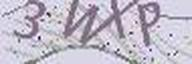

In [3]:
import string
characters = '-' + string.digits + string.ascii_uppercase
width, height, n_len, n_classes = 192, 64, 4, len(characters)#192 64
n_input_length = 12
batch_size = 70
print(CaptchaDataset(characters, 1000 * batch_size, width, height, n_input_length, n_len).__getitem__(0))


im = Image.open("./2.jpg")
# 转 np
np_im = np.array(im)
# 转 tensor
b = torch.from_numpy(np.transpose(np_im,  (2, 0, 1)))
# 归一化
b = b / 255
print(b)
print(b.shape)
to_pil_image(b)

In [8]:
import torch
import torch.nn as nn

from collections import OrderedDict

class Model(nn.Module):
    def __init__(self, n_classes, input_shape=(3, 64, 128)):
        super(Model, self).__init__()
        self.input_shape = input_shape
        channels = [32, 64, 128, 256, 256]
        layers = [2, 2, 2, 2, 2]
        kernels = [3, 3, 3, 3, 3]
        pools = [2, 2, 2, 2, (2, 1)]
        modules = OrderedDict()

        def cba(name, in_channels, out_channels, kernel_size):
            modules[f'conv{name}'] = nn.Conv2d(in_channels, out_channels, kernel_size,
                                               padding=(1, 1) if kernel_size == 3 else 0)
            modules[f'bn{name}'] = nn.BatchNorm2d(out_channels)
            modules[f'relu{name}'] = nn.ReLU(inplace=True)

        last_channel = 3
        for block, (n_channel, n_layer, n_kernel, k_pool) in enumerate(zip(channels, layers, kernels, pools)):
            for layer in range(1, n_layer + 1):
                cba(f'{block+1}{layer}', last_channel, n_channel, n_kernel)
                last_channel = n_channel
            modules[f'pool{block + 1}'] = nn.MaxPool2d(k_pool)
        modules[f'dropout'] = nn.Dropout(0.25, inplace=True)
        self.cnn = nn.Sequential(modules)
        self.lstm = nn.LSTM(input_size=self.infer_features(), hidden_size=128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)
    
    def infer_features(self):
        x = torch.zeros((1,)+self.input_shape)
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        return x.shape[1]

    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x


In [5]:
import string
# -0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
characters = '-' + string.digits + string.ascii_uppercase

def decode(sequence):
    a = ''.join([characters[x] for x in sequence])
    s = ''.join([x for j, x in enumerate(a[:-1]) if x != characters[0] and x != a[j+1]])
    if len(s) == 0:
        return ''
    if a[-1] != characters[0] and s[-1] != a[-1]:
        s += a[-1]
    return s


In [9]:
model = Model(n_classes, input_shape=(3, height, width))

state_dict = torch.load("./ctc3.pth")
model.load_state_dict(state_dict)

model.eval()

ModuleNotFoundError: No module named 'Model'